<font size = "5"> **Chapter 2: [Diffraction](../Diffraction/CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

#  Homework 4

<font size = "5"> Analyzing Spot Diffraction Pattern </font>

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Homework/Homework03.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.


## Overview
This homework follows the notebook:
[Analyzing Spot Diffraction Pattern](../Diffraction/CH2_08-Spot_Diffraction_Pattern.ipynb)


## Load relevant python packages
### Check Installed Packages

In [2]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2023.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib
print('done')

done


### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library.

In [3]:
%matplotlib  notebook
import matplotlib.pyplot as plt
import numpy as np

# 3D and selection plotting package 
from mpl_toolkits.mplot3d import Axes3D # 3D plotting
from matplotlib.widgets import  EllipseSelector
%gui qt


# additional package 
import itertools 
import scipy.constants as const
import os

# Import libraries from the book
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # with Atomic form factors from Kirklands book
import pyTEMlib.file_tools as ft     

from skimage.feature import blob_dog

# it is a good idea to show the version numbers at this point for archiving reasons.
__notebook_version__ = '2022.02.18'
print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2023.2.0
notebook version:  2022.02.18



## Load Spot-Diffraction Pattern



### First we select the diffraction pattern

In the second lab we used a sample of either gold (Tuesday) or Aluminium (Wednesday) 

Download your images from the google drive at https://drive.google.com/drive/folders/1TId7PiGUbip8m8JgX2FL5PaNjld1idzt?usp=sharing

> You must log into Google with your UTK account to be able to read these data.
>

Go to the folder of you data and select one  
The dynamic range of diffraction patterns is too high for computer screens and so we take the logarithm of the intensity. 

<IPython.core.display.Javascript object>


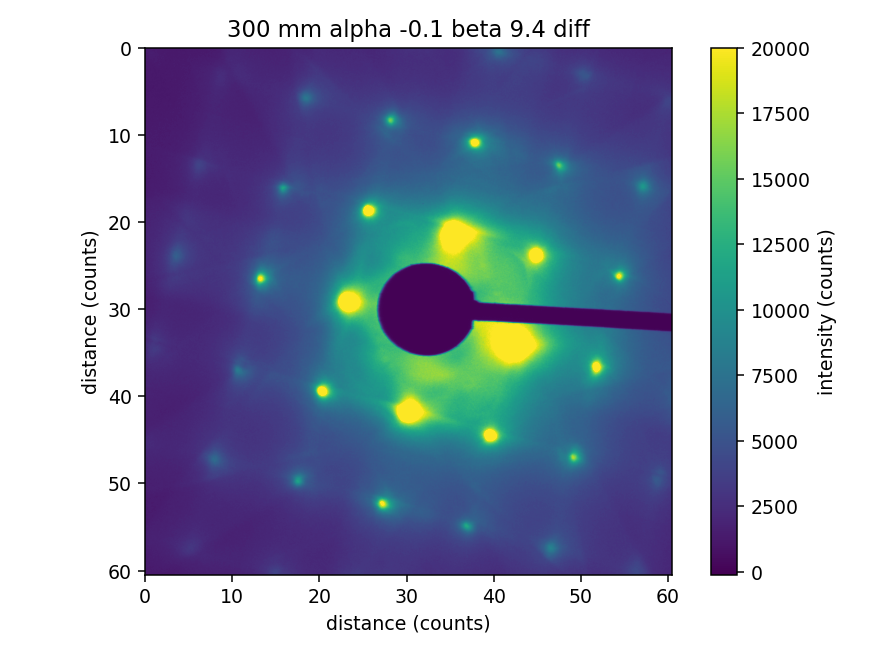

In [4]:
# ------Input -------------
load_your_own_data = False
# -------------------------

if load_your_own_data:
    datasets = ft.open_file()
else:  # load example    
    datasets = ft.open_file(os.path.join("../example_data", "Si001_300mm_alpha0.1_beta9.4_diff.dm3"))
main_dataset = datasets['Channel_000']

view = main_dataset.plot(vmax=20000)

## Finding the center

### Select the center yourself
Select the center of the screen with the ellipse selection tool

<IPython.core.display.Javascript object>


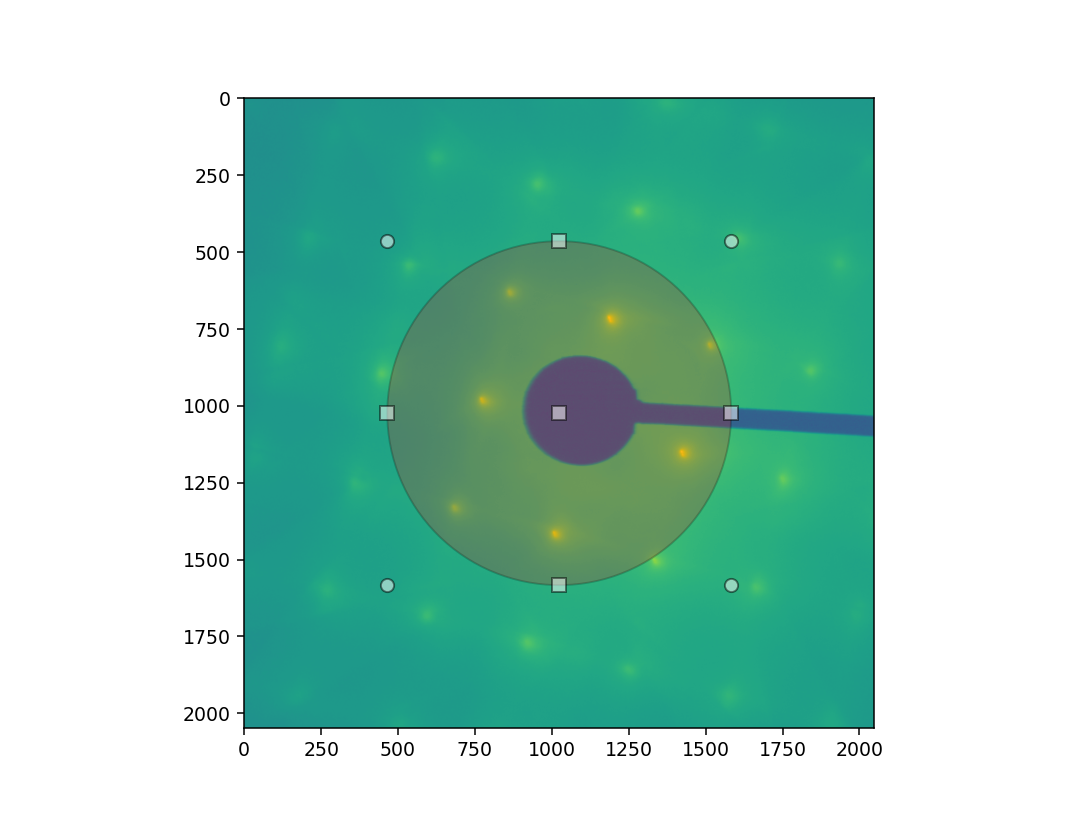

In [5]:
## Access the data of the loaded image
radius = 559 
diff_pattern = np.array(main_dataset.T)
diff_pattern = diff_pattern-diff_pattern.min()

center = np.array([1024, 1024])

plt.figure(figsize=(8, 6))
plt.imshow(np.log(3.+diff_pattern), origin='upper')
current_axis = plt.gca()
selector = EllipseSelector(current_axis, None, interactive=True)  # gca get current axis (plot)
center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)

Get center coordinates from selection

In [7]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - diff_pattern.shape[0]/2
y_shift = y_center - diff_pattern.shape[1]/2
print(f'radius = {(xmax-xmin)/2:.0f} pixels')

center = (x_center, y_center )
print(f'center = {center} [pixels]')

out_tags ={}
out_tags['center'] = center

radius = 559 pixels
center = (1112.6580086580088, 1046.1645021645022) [pixels]


## Determine Bragg Peaks

Peak finding is actually not as simple as it looks

<IPython.core.display.Javascript object>


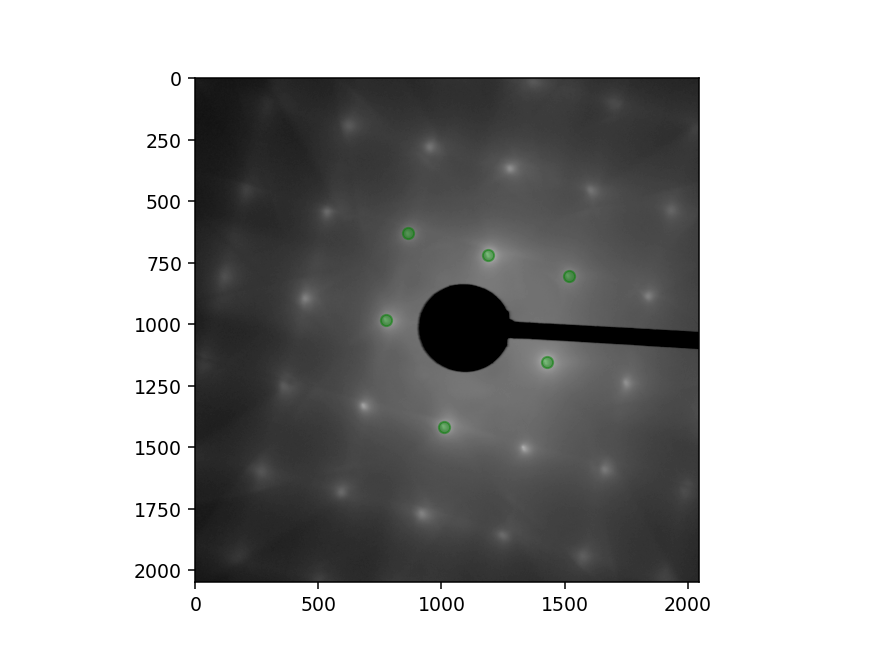

In [15]:
# ----- Input -----#
threshold = 0.9
# -----------------#

# The beam stop is rather dark
beam_stop = np.argwhere(diff_pattern.T < 100)

# Determine all spots

dif = np.log2(1+diff_pattern)
dif = dif-dif.min() # blog detector does not like negative values
spots = blob_dog(dif.T, max_sigma=12, threshold=threshold)

Bragg_spots = []
# We only consider spots not associated with the beam stop (which confuses the blob finder)
for spot in spots:
    if np.min(np.linalg.norm(beam_stop-spot[:2], axis=1))> 100:
        Bragg_spots.append(spot[0:2])
Bragg_spots = np.array(Bragg_spots)
Bragg_spots = Bragg_spots[np.argsort(np.linalg.norm(Bragg_spots[:,:2]-center, axis=1)),:]

plt.figure()
plt.imshow(np.log2(1+diff_pattern),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)

plt.scatter(Bragg_spots[:,0], Bragg_spots[:,1], c='green',  alpha = 0.5)




### Refine Center

We use the N innermost reflections and the average of those positions is the new center

> Please choose the max_distance value so that you have a symmetric selection of Bragg spots around the center 

<IPython.core.display.Javascript object>


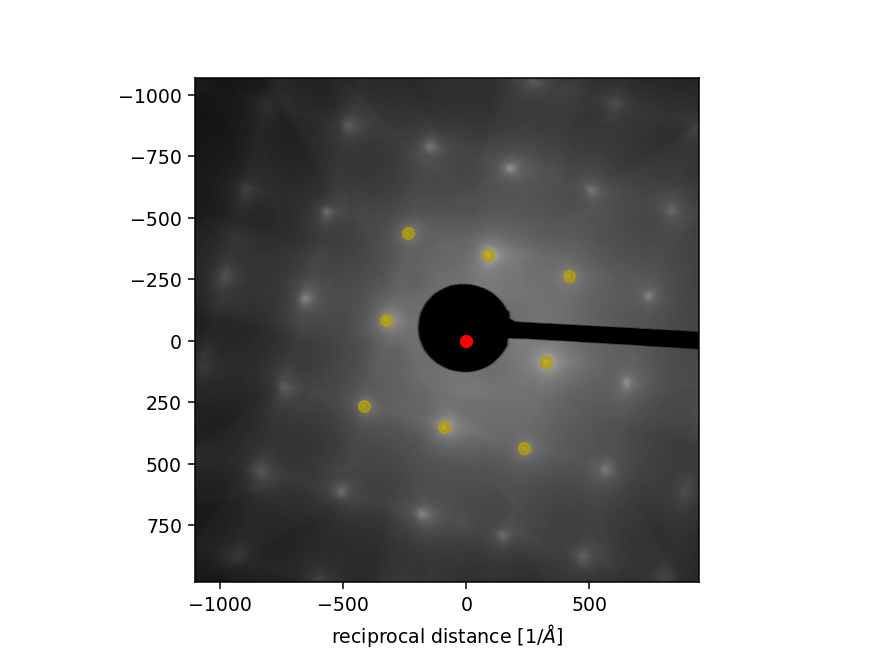

In [10]:
# ----- Input -------------
max_distance = 600 # pixel
# -------------------------

close_spots = Bragg_spots[np.linalg.norm(Bragg_spots[:,:2]-center[:2], axis=1) <max_distance]

refined_center = np.average(close_spots, axis=0)
close_spots -= refined_center

spots_experiment = (Bragg_spots-refined_center)

fig = plt.figure()
extent= np.array([-refined_center[0], diff_pattern.shape[0]-refined_center[0],
                  diff_pattern.shape[1]-refined_center[1], -refined_center[1]])
plt.imshow(np.log2(1+diff_pattern), cmap="gray", extent=extent, vmin=np.max(np.log2(1 + diff_pattern)) * 0.5)

plt.scatter(spots_experiment[:,0], spots_experiment[:,1], c='green',  alpha = 0.5,
           label='spots')
plt.scatter(close_spots[:,0], close_spots[:,1], c='orange',  alpha = 0.5,
           label='close spots')

plt.xlabel('reciprocal distance [1/$\AA$]')
plt.scatter(0, 0, color='red')

## Calculate Spot Pattern

see [Plotting of Diffraction Pattern](CH2_07-Plotting_Diffraction_Pattern.ipynb) for details


In [11]:
# -------Input  -----
material = 'silicon'
zone_hkl = [0,0,1]
# -------------------

atoms  = ks.structure_by_name(material)
atoms.info['experimental']={}
### Define experimental parameters:
atoms.info['experimental']['acceleration_voltage_V'] = 200.0 *1000.0 #V
atoms.info['experimental']['new_figure'] = False
atoms.info['experimental']['plot FOV'] = 3  # in 1/Ang
atoms.info['experimental']['convergence_angle_mrad'] = 0
atoms.info['experimental']['zone_hkl'] = np.array(zone_hkl)  # incident nearest zone axis: defines Laue Zones!!!!
atoms.info['experimental']['mistilt']  = np.array([0,0,0])  # mistilt in degrees
atoms.info['experimental']['Sg_max'] = .04 # 1/Ang  maximum allowed excitation error ; This parameter is related to the thickness
atoms.info['experimental']['hkl_max'] = 15   # Highest evaluated Miller indices

######################################
# Diffraction Simulation of Crystal #
######################################

d = ks.kinematic_scattering(atoms, verbose = True)


The inner potential is 46.5 V
Using an acceleration voltage of 200.0kV
Magnitude of incident wave vector in material: 39.8771 1/Ang and in vacuum: 39.8735 1/Ang
Which is an wave length of 2.508 pm in the material and 2.508 pm in the vacuum
The convergence angle of 0.0mrad = 0.00 1/A
Magnitude of incident wave vector in material: 39.9 1/A which is a wavelength 2.508 pm
Rotation alpha 0.0 degree,  beta 0.0 degree
from zone axis [0 0 1]
Tilting 1 by 0.00  in alpha and 0.00 in beta direction results in :
Next nearest zone axes are:
Center of Ewald sphere  [ 0.          0.         39.87709806]
Of the 29790 tested reciprocal_unit_cell points, 348 have an excitation error less than 0.04 1/nm
Of the 348 possible reflection 56 are allowed.
Laue_circle [0. 0. 0.]
 There are 36 allowed reflections in the zero order Laue Zone
 There are 20 allowed reflections in the first order Laue Zone
 There are 0 allowed reflections in the second order Laue Zone
 There are 0 allowed reflections in the other hi

## Comparison
Comparison between experimental pattern and kinematic theory

Experimental Bragg reflection in polar coordinates

In [12]:
print('distance [pixel]   angle [degree] ')
for spot in close_spots:
    
    print(f'{np.linalg.norm(spot):8.3f} \t {np.degrees(np.arctan2(spot[0], spot[1])):5.1f}  ' )


distance [pixel]   angle [degree] 
 336.784 	  75.3  
 360.840 	 165.6  
 336.300 	 -104.7  
 360.716 	 -14.3  
 492.756 	 122.5  
 496.333 	 -151.6  
 496.095 	  28.4  
 493.178 	 -57.6  


Select the largest g distance that you want to have indexed.

In [13]:
# ----- Input ------
max_g_length = 1.
# ------------------
allowed_g = atoms.info['diffraction']['allowed']['g']
allowed_hkl = atoms.info['diffraction']['allowed']['hkl']

close = np.where(np.linalg.norm(allowed_g[:, :2], axis=1)<max_g_length)
smallest_reciprocal_length = np.min(np.linalg.norm(allowed_g[:, :2], axis=1))

print(f' Smallest reciprocal length is {smallest_reciprocal_length:.3f} 1/Ang')
print()
                    
                                    
print('  hkl          coordinates             lengths in 1/Ang\n')
for index in close[0]:
    print(allowed_hkl[index], '\t', np.round(allowed_g[index], 3), '\t',
          np.linalg.norm(allowed_g[index]))
print(smallest_reciprocal_length )


 Smallest reciprocal length is 0.521 1/Ang

  hkl          coordinates             lengths in 1/Ang

[-4.  0.  0.] 	 [-0.737  0.     0.   ] 	 0.7365288866629349
[-2. -2.  0.] 	 [-0.368 -0.368  0.   ] 	 0.5208045702991394
[-2.  2.  0.] 	 [-0.368  0.368  0.   ] 	 0.5208045702991394
[ 0. -4.  0.] 	 [ 0.    -0.737  0.   ] 	 0.7365288866629349
[0. 4. 0.] 	 [0.    0.737 0.   ] 	 0.7365288866629349
[ 2. -2.  0.] 	 [ 0.368 -0.368  0.   ] 	 0.5208045702991394
[2. 2. 0.] 	 [0.368 0.368 0.   ] 	 0.5208045702991394
[4. 0. 0.] 	 [0.737 0.    0.   ] 	 0.7365288866629349
0.5208045702991394


Enter the distance from center for one of the closest experimental Bragg reflections in pixel with assoicated angle

<IPython.core.display.Javascript object>


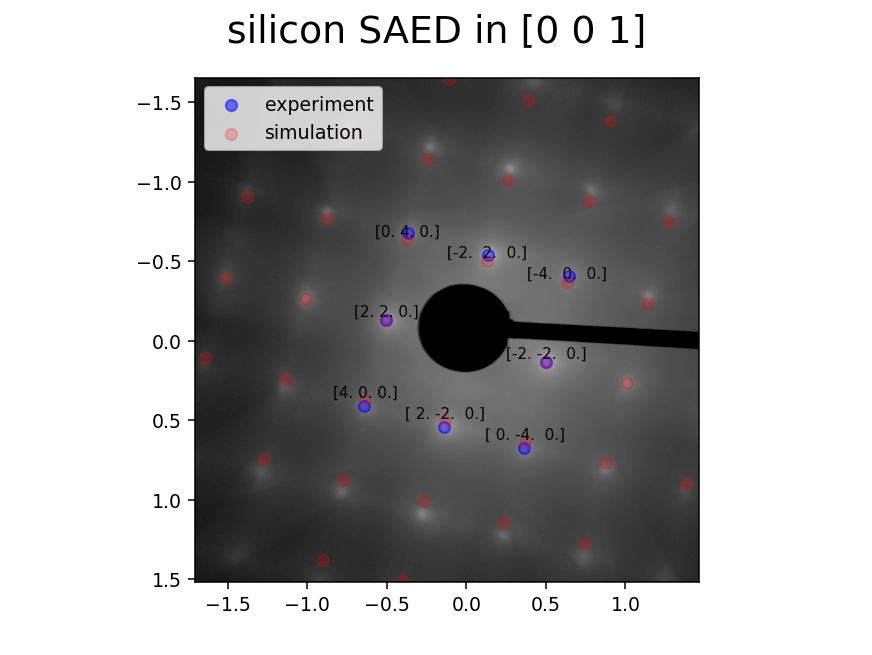

In [14]:
# -------Input of grain size ----
first_peak_length_in_pixel = 336.78377
rotation_angle = 75.29323
# degrees
# -------------------------------

first_peak_reciprocal_distance =  np.min(np.linalg.norm(allowed_g[:,:2], axis=1))
pixel_size = first_peak_reciprocal_distance/first_peak_length_in_pixel
closest_sim = np.argmin(np.linalg.norm(allowed_g[:,:2], axis=1))

angle_closest_reflection = np.degrees(np.arctan2(allowed_g[closest_sim,1], allowed_g[closest_sim,0]))

rotation_angle = rotation_angle - angle_closest_reflection
tags_simulation = atoms.info['diffraction']

scaled_extent= extent*pixel_size

angle = np.radians(rotation_angle)
c = np.cos(angle)
s = np.sin(angle)
r_mat = np.array([[c,-s,0],[s,c,0],[0,0,1]])
rmat_g= r_mat

spots_experiment_scaled = spots_experiment*pixel_size

spots_simulation =  np.dot(allowed_g, r_mat)
spots_ZOLZ = spots_simulation[atoms.info['diffraction']['allowed']['ZOLZ']]

fig = plt.figure()
fig.suptitle(material+' SAED in ' + str( atoms.info['experimental']['zone_hkl']), fontsize=20) 
plt.scatter(spots_experiment_scaled[:,0], spots_experiment_scaled[:,1], c='blue',  alpha = 0.5, label='experiment')
plt.scatter(spots_simulation[:,0], spots_simulation[:,1], c='red',  alpha = 0.2,   label='simulation')
plt.imshow(np.log2(1+diff_pattern), cmap="gray", extent=scaled_extent, vmin=np.max(np.log2(1 + diff_pattern)) * 0.5)
for i in range(len(spots_simulation)):
    if np.linalg.norm(spots_simulation[i]) < max_g_length:
        plt.text(spots_simulation[i,0], spots_simulation[i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
plt.legend()

## Homework

Index the diffraction pattern for two different zone axes.

Submit two notebooks each with a diffraction pattern of a different zone axis

**Optional:**
> Plot the indicated camera length over the pixel size!


In [23]:
for i in range(len(spots_simulation)):
    if np.linalg.norm(spots_simulation[1]) <1:
        print(tags_simulation['allowed']['hkl'][i])